# Importing libraries

In [1]:
import timeit
import numpy as np
import cupy as cp
from cupyx.scipy.linalg import toeplitz as cutoeplitz
from cupyx.scipy.signal import fftconvolve as cufftconvolve
from cupyx.scipy.fft import fft as cufft
from cupyx.scipy.fft import ifft as cuifft
from cupyx.scipy.sparse import csr_matrix as rsparse_matrix
from cupyx.scipy.sparse import csc_matrix as csparse_matrix
import matplotlib.pyplot as plt
from tqdm import tqdm
import scipy
from scipy import sparse, signal, ndimage
from scipy.linalg import toeplitz, matmul_toeplitz, circulant

## The algorithm from the preprint with GPU via cupy

In [2]:
def MyConvCP(X, K):
    """
    Intput:
    X - cupy.array, image
    K - cupy.array, kernel
    Output:
    2D convolution of X and K; type copy.Tensor
    """
    p, q = K.shape
    m, n = X.shape
    row = cp.zeros(n-q+1)
    row[0] = K[0, 0]
    col = cp.pad(K, ((0,0),(0,n-q)), mode="constant")
    col = col.reshape((-1,))
    A = cutoeplitz(col, row)
    reshapedX = X.reshape((-1,))
    indx = cp.arange(0, (m-p+1)*n, n).reshape(-1,1) + cp.arange(n*p)
    B = reshapedX[indx]
    return B@A

### Convolution from scipy that uses FFT (GPU)

In [3]:
def scconvCP(x, y):
    """
    Intput:
    X - cupy.array, image
    K - cupy.array, kernel
    Output:
    2D convolution of X and K; type copy.Tensor
    """
    y_flipped = cp.flip(y)
    return cufftconvolve(x, y_flipped, mode = 'valid')

## Testing Outputs

In [4]:
m, n = 7, 7
p, q = 3, 3
X = np.random.normal(size=(m, n))
K = np.random.normal(size=(p, q))

In [5]:
XCP = cp.array(X)
KCP = cp.array(K)
MyConvCP(XCP, KCP)

array([[ 3.37283458, -1.20942966, -2.02987655, -1.24739327,  1.23428278],
       [-4.0020413 , -1.52331953,  0.41561838, -0.94251992,  0.97767242],
       [-4.4984825 ,  1.94470377,  3.38499313,  2.1768099 , -1.0827751 ],
       [ 0.47305184, -0.71638185,  5.11037034, -1.42775837, -3.36379548],
       [ 1.8300618 ,  0.9345587 ,  0.70731788,  2.16275579, -2.91490529]])

In [6]:
scconvCP(XCP, KCP)

array([[ 3.37283458, -1.20942966, -2.02987655, -1.24739327,  1.23428278],
       [-4.0020413 , -1.52331953,  0.41561838, -0.94251992,  0.97767242],
       [-4.4984825 ,  1.94470377,  3.38499313,  2.1768099 , -1.0827751 ],
       [ 0.47305184, -0.71638185,  5.11037034, -1.42775837, -3.36379548],
       [ 1.8300618 ,  0.9345587 ,  0.70731788,  2.16275579, -2.91490529]])

## Generating random images

In [7]:
image_size = 100 # image size, square image, 
kernel_size = 40 # kernel size
iterations = 500 # number of images
images = np.random.normal(size=(iterations, image_size, image_size))
kernels = np.random.normal(size=(iterations, kernel_size, kernel_size))
set_of_images = [(x, y) for x, y in zip(images, kernels)]
set_of_images_cp = [(cp.array(x), cp.array(y)) for x, y in zip(images, kernels)]

# Benchmark - measuring comp. times

### My Conv with cupy (GPU)

In [8]:
starttime = timeit.default_timer()
for x in set_of_images_cp: 
    MyConvCP(*x)
print("The time difference is :", timeit.default_timer() - starttime)

The time difference is : 0.09972514095716178


### Scipy FFT convolve (GPU)

In [9]:
starttime = timeit.default_timer()
for x in set_of_images_cp: 
    scconvCP(*x)
print("The time difference is :", timeit.default_timer() - starttime)

The time difference is : 0.12609161395812407


## Long benchmark

In [10]:
def generate_times(
    convfun,
    cupy_cond=False,
    trials=5):
    image_size = 100
    iter_size = 100
    time_overall = []
    for kernel_size in tqdm(range(1, image_size), desc="Kernel size"):
        images = np.random.uniform(0, 1, size=(trials, iter_size, image_size, image_size))
        kernels = np.random.normal(size=(trials, iter_size, kernel_size, kernel_size))
        for j in range(trials):
            time_diff_result = []
            set_of_images = []
            for k in range(iter_size):
                X = images[j][k]
                K = kernels[j][k]
                if cupy_cond:
                    X = cp.array(X)
                    K = cp.array(K)
                set_of_images.append([X, K])
            starttime = timeit.default_timer()
            for x in set_of_images: 
                convfun(*x)
            time_diff =  timeit.default_timer() - starttime
            time_diff_result.append(time_diff)
        time_overall.append(time_diff_result)
    return np.array(time_overall).mean(axis=1)

In [11]:
time_conv_sc_cp = generate_times(scconvCP, cupy_cond=True)

Kernel size: 100%|██████████████████████████████| 99/99 [00:20<00:00,  4.83it/s]


In [12]:
time_conv_myalg_gpu = generate_times(MyConvCP, cupy_cond=True)

Kernel size: 100%|██████████████████████████████| 99/99 [00:19<00:00,  5.10it/s]


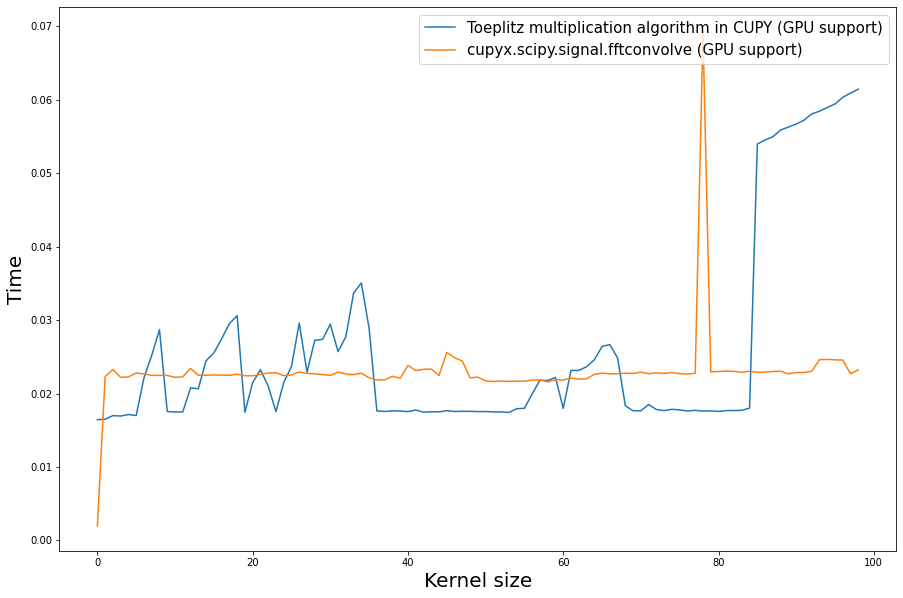

In [13]:
fig = plt.figure(figsize=(15,10))
plt.plot(time_conv_myalg_gpu, label="Toeplitz multiplication algorithm in CUPY (GPU support)")
plt.plot(time_conv_sc_cp, label="cupyx.scipy.signal.fftconvolve (GPU support)")
#plt.plot(time_conv_tf, label="tensorflow.nn.conv2d (GPU support)")
plt.plot()
plt.legend(loc="upper right", fontsize=15)
plt.xlabel("Kernel size", fontsize=20)
plt.ylabel("Time", fontsize=20)
fig.savefig("conv2d_gpu.jpg")
plt.show()

In [16]:
x = np.arange(5, 100, 5)
y1 = time_conv_sc_cp[x]
y2 = time_conv_myalg_gpu[x]
#y3 = time_conv_tf[x]

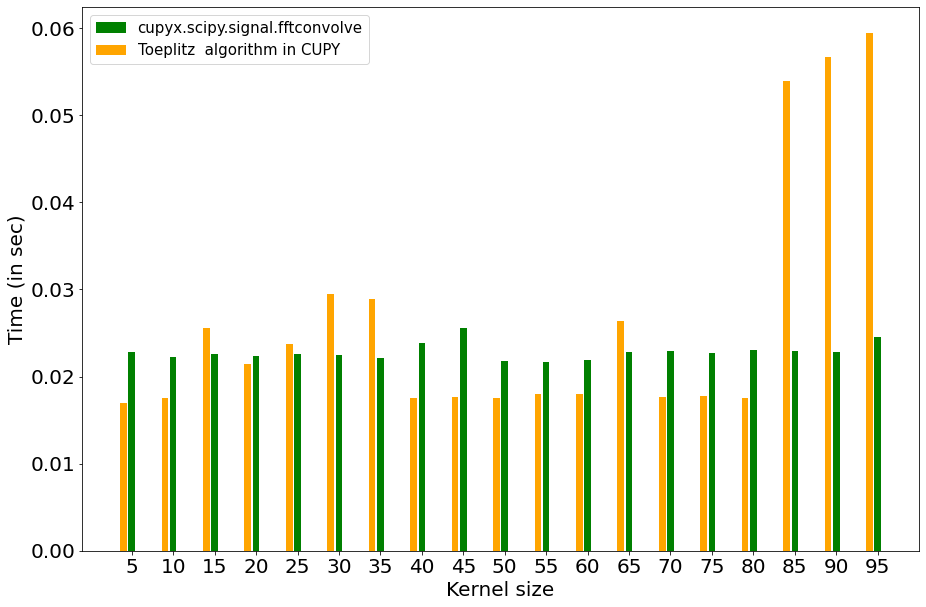

In [18]:
fig = plt.figure(figsize=(15,10))
plt.bar(x,y1, color="green", label="cupyx.scipy.signal.fftconvolve")
plt.bar(x-1,y2, color="orange", label="Toeplitz  algorithm in CUPY")
#plt.bar(x+1,y3, color="red", label="tensorflow.nn.conv2d")
plt.legend(loc="upper left", fontsize=15)
plt.xlabel("Kernel size", fontsize=20)
plt.xticks(x, fontsize=20)
plt.ylabel("Time (in sec)", fontsize=20)
plt.yticks(fontsize=20)
fig.savefig("conv2d_gpu.jpg")
plt.show()